# Визуализация данных по самым частым леммам японского языка
В данном датасете представлены данные по частотам 15000 самых употребляемых лемм японского языка. Подгрузим данные и посмотрим на их структуру.

In [1]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from charguana import get_charset

In [2]:
data = pd.read_csv('./japanese_lemmas.csv')

In [3]:
data.head(10)

,rank,frequency,lemma
0,1,41309.50,の
1,2,23509.54,に
2,3,22216.80,は
3,4,20431.93,て
4,5,20326.59,を
5,6,20110.69,が
6,7,19235.55,だ
7,8,17292.36,た
8,9,16841.17,する
9,10,15095.29,と


Как вы можете видеть, все леммы сортированы по частотам и ранжированы. Для начала построим графики распределений частот лемм в зависимости от их длины.

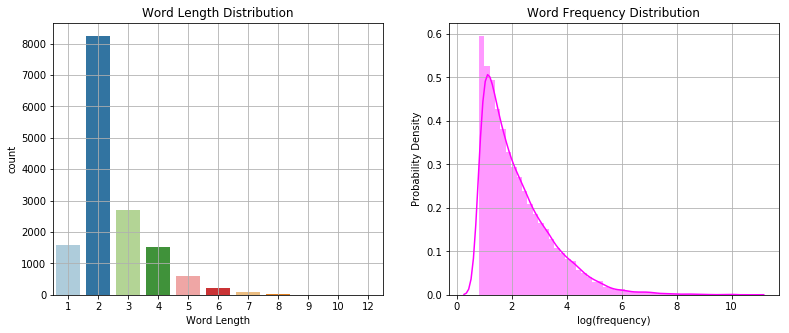

In [4]:
data["len"] = data['lemma'].apply(lambda x: len(x))

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 5))
sns.countplot(data["len"], palette="Paired", ax=ax[0])
ax[0].set_xlabel('Word Length')
ax[0].grid()
ax[0].set_title("Word Length Distribution")
sns.distplot(data["frequency"].apply(lambda x: np.log(x)), color='magenta', ax=ax[1])
ax[1].set_xlabel("log(frequency)")
ax[1].set_ylabel("Probability Density")
ax[1].set_title("Word Frequency Distribution")
ax[1].grid()
plt.show()

Как вы можете видеть, распределение имеет характерную форму, обусловленную законом Ципфа, который утверждает, что для корпуса естественного языка (японского, корейского и т. д.), частота каждой леммы обратно пропорциональна её рангу. Иначе говоря, слово с рангом 1 встречается в языке в два раза чаще, чем слово с рангом 2, в три раза чаще, чем слово с рангом 3 и т. д.  
Попробуем теперь построить распределения частот для глаголов и остальных частей речи. Для этого учтем, что все глаголы в японском оканчиваются на определенные окончания (окуригана):

In [6]:
verb_endings = ['う','く','す','つ','む','ぬ','る','ぐ','ぶ']

data['verb indicator'] = data['lemma'].apply(lambda x: x[-1] in verb_endings)

print("Процент слов, которые, вероятно, являются глаголами: ",
      round(100*data['verb indicator'].sum()/len(data),2),'%')
data[data['verb indicator']].head(5)

Процент слов, которые, вероятно, являются глаголами:  13.48 %


,rank,frequency,lemma,len,verb indicator
8,9,16841.17,する,2,True
10,11,9604.49,ます,2,True
13,14,8140.22,いる,2,True
15,16,6766.19,ある,2,True
17,18,5780.62,です,2,True


>> Распределения частот слов по длинам, распределения логарифмов частот глаголов и остальных слов японского языка


Text(0.5, 1.0, 'Распределения частот слов по длинам')

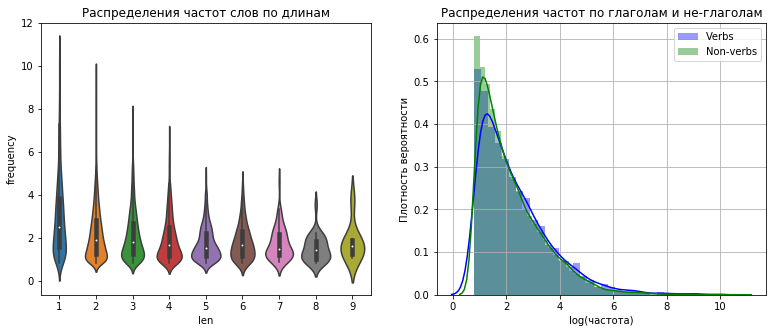

In [36]:
data_not_skewed = data[data["len"]<10] # Исключим точки, сильно отклоняющиеся по длине
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 5))
sns.violinplot(data_not_skewed["len"], data_not_skewed["frequency"].apply(lambda x: np.log(x)), ax=ax[0])

data["log freq"] = data["frequency"].apply(lambda x: np.log(x))

print(">> Распределения частот слов по длинам, распределения логарифмов частот глаголов и остальных слов японского языка")
verbs = []
non_verbs = []
for dummy_i in range(len(data["verb indicator"])):
    if data["verb indicator"][dummy_i] == False:
        non_verbs.append(np.log(data["frequency"][dummy_i]))
    else:
        verbs.append(np.log(data["frequency"][dummy_i]))
sns.distplot(verbs, color='blue', ax=ax[1], label="Verbs")
sns.distplot(non_verbs, color='green', ax=ax[1], label="Non-verbs")
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("log(частота)")
ax[1].set_ylabel("Плотность вероятности")
ax[1].set_title("Распределения частот по глаголам и не-глаголам")
ax[0].set_title("Распределения частот слов по длинам")

Как вы можете видеть выше, слева построен график распределений частот с учетом разных длин слов: для всех слов определенной длины построены свои распределения. 

In [9]:
data.head(10)

,rank,frequency,lemma,len,verb indicator,log freq
0,1,41309.50,の,1,False,10.628848
1,2,23509.54,に,1,False,10.065162
2,3,22216.80,は,1,False,10.008604
3,4,20431.93,て,1,False,9.924854
4,5,20326.59,を,1,False,9.919685
5,6,20110.69,が,1,False,9.909007
6,7,19235.55,だ,1,False,9.864515
7,8,17292.36,た,1,False,9.758020
8,9,16841.17,する,2,True,9.731582
9,10,15095.29,と,1,False,9.622138


Подсчитаем теперь, как распределены между собой разные типы письменности в японском: хирагана, катакана и кандзи. Слова, состоящие из исключительно каны, распределены по двум группам, а слова, имеющие в своем составе кандзи -- объединены в третью группу. 

In [60]:
# Syllables. 
hiragana = set(get_charset('hiragana'))
katakana = set(get_charset('katakana'))

# Punctuations.
punctuation = set(get_charset('cjk_punctuation'))

# Kanji characters are other characters in the "japanese" set.
kanji = set(get_charset('japanese')) - hiragana - katakana - punctuation

def is_charset(s, charset):
    return len(set(s).intersection(charset)) == len(s)

# Analyse lemmas and classify them either as katakana, hiragana, or kanji
charset = {'hiragana': [], 'kanji': [], 'katakana': []}

for idx, row in data.iterrows():
    lemma = row['lemma']
    if is_charset(lemma, hiragana):
        k = 'hiragana'
    elif is_charset(lemma, katakana):
        k = 'katakana'
    else: 
        k = 'kanji'
    charset[k].append(idx)

num_of_lemmas = len(data)
print(len(charset['hiragana']), 'из', num_of_lemmas, 'являются хираганой.')
print(len(charset['katakana']), 'из', num_of_lemmas, 'являются катаканой.')
print(len(charset['kanji']), 'из', num_of_lemmas, 'содержат кандзи.')

1517 из 15000 являются хираганой.
2154 из 15000 являются катаканой.
11329 из 15000 содержат кандзи.


Text(0, 0.5, 'Абсолютное число лемм')

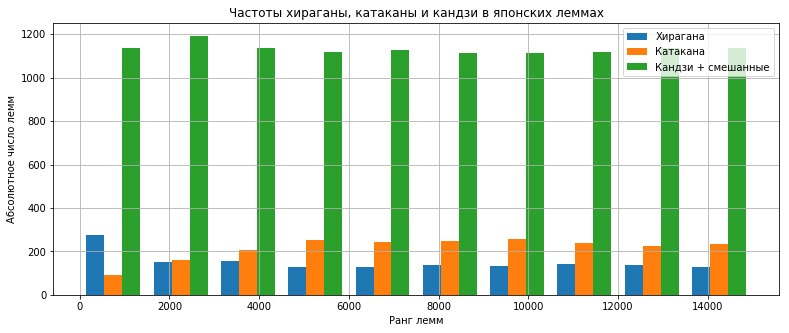

In [65]:
figure = plt.figure(figsize=(13,5))
ax1 = figure.add_subplot(111)
ax1.grid()
ax1.hist(x=[charset["hiragana"], charset["katakana"], charset["kanji"]], label=["Хирагана", "Катакана", "Кандзи + смешанные"])
ax1.legend()
ax1.set_title("Частоты хираганы, катаканы и кандзи в японских леммах")
ax1.set_xlabel("Ранг лемм")
ax1.set_ylabel("Абсолютное число лемм")

Напоследок посмотрим, выполняется ли закон Ципфа для отдельных символов и дополнительно построим графики ранг-логарифм частоты для всех лемм и всех символов, встречаемых в этом дата-сете. Как вы можете видеть, графики хорошо согласуются с теоретической моделью.

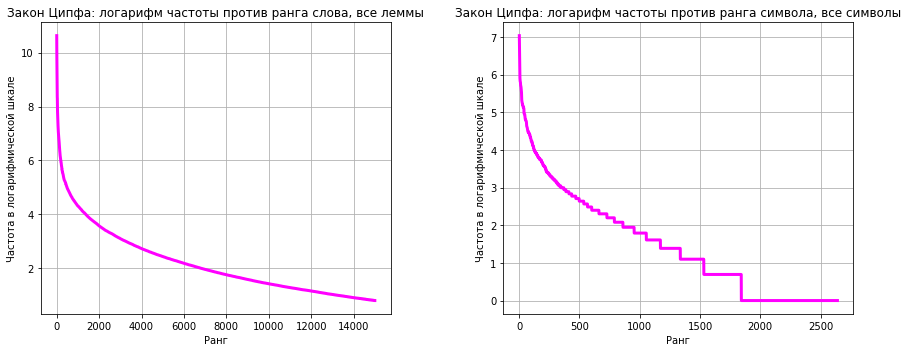

In [126]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(13, 5))
ax[0].plot(data["rank"], data["log freq"], linewidth=3, color='magenta')
ax[0].set_title("Закон Ципфа: логарифм частоты против ранга слова, все леммы")
ax[0].set_xlabel("Ранг")
ax[0].set_ylabel("Частота в логарифмической шкале")
ax[0].grid() 

all_lemmas = data["lemma"].tolist()
all_lemmas = ''.join(all_lemmas)
all_characters = dict.fromkeys(all_lemmas, 0)
for dummy_i in range(len(data["lemma"])):
    for dummy_j in data["lemma"][dummy_i]:
        all_characters[dummy_j] += 1
characters_df = pd.DataFrame.from_dict(all_characters, orient="index", columns=["frequency"])
characters_df['log freq'] = characters_df['frequency'].apply(lambda x: np.log(x))
characters_df = characters_df.sort_values(by=["frequency"], ascending = False).reset_index()
characters_df = characters_df.rename(columns={"index": "character"})
characters_df["rank"] = characters_df["frequency"].rank(method="first", ascending=False)
        
ax[1].plot(characters_df["rank"], characters_df["log freq"], linewidth=3, color='magenta')
ax[1].grid()
ax[1].set_title("Закон Ципфа: логарифм частоты против ранга символа, все символы")
ax[1].set_xlabel("Ранг")
ax[1].set_ylabel("Частота в логарифмической шкале")

plt.tight_layout()
plt.show()

In [121]:
characters_df.head(10)

,character,frequency,log freq,rank
0,る,1135,7.034388,1.0
1,ー,873,6.771936,2.0
2,ン,673,6.511745,3.0
3,い,603,6.401917,4.0
4,ス,401,5.993961,5.0
5,ト,368,5.908083,6.0
6,ル,342,5.834811,7.0
7,す,338,5.823046,8.0
8,り,333,5.808142,9.0
9,し,329,5.796058,10.0
